In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
'''
实测，不加上面这一行内核会崩溃 deepseek说一般在Mac上需要这一行，我测试的环境是Windows
另外，文件名如果是`code.ipynb`，内核会崩溃，改成`solution.ipynb`后正常了
'''

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
class Net(torch.nn.Module):
    def __init__(self):
        '''先调用父类的__init__函数，然后定义了四个全连接层'''
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, 10)
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc3(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        '''soft_max归一化为10个值为0~1之间且和为1的值，这里额外做了一个log'''
        return x

In [3]:
def get_data_loader(is_train):
    to_tensor = transforms.Compose([transforms.ToTensor()])
    data_set = datasets.MNIST("", is_train, transform=to_tensor,download=True)
    '''
        不加transform = to_tensor参数 每个元素构成是[Image,label]
        加上transform = to_tensor参数 Image变成了一个三维张量，第一维是通道数，第二维和第三维是图片像素数
        且单个像素的值由0~255的灰度值归一化为了0~1的值
        （图片像素数是28*28，第二维和第三维的大小都是28）
    '''
    return DataLoader(data_set, batch_size=15, shuffle=True)
data_origin = datasets.MNIST("", True, download=True)
image_origin,label = data_origin[0]
print(type(image_origin))
size = image_origin.size
print(size)
for i in range(size[0]):
    for j in range(size[1]):
        print(image_origin.getpixel((i, j)),end = ' ')
    print('')
print('-------------------------------')
to_tensor = transforms.Compose([transforms.ToTensor()])
data_to_tensor = datasets.MNIST("", True, transform=to_tensor,download=True)
image_tensor,label = data_to_tensor[0]
shape = image_tensor.shape
print(shape)
print(image_tensor[0][0][0])
for i in range(shape[1]):
    for j in range(shape[2]):
        print('{:.2f}'.format(image_tensor[0][i][j].item()),end = ' ')
    print('')

<class 'PIL.Image.Image'>
(28, 28)
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 55 136 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 172 253 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 18 226 253 0 0 0 
0 0 0 0 0 0 0 49 18 0 0 0 0 0 0 0 0 0 0 0 0 0 171 253 253 0 0 0 
0 0 0 0 0 0 30 238 219 80 0 0 0 0 0 0 0 0 0 0 0 23 219 253 212 0 0 0 
0 0 0 0 0 0 36 253 253 156 14 0 0 0 0 0 0 0 0 0 0 66 253 253 135 0 0 0 
0 0 0 0 0 0 94 253 253 107 1 0 0 0 0 0 0 0 0 0 24 213 253 253 132 0 0 0 
0 0 0 0 0 0 154 253 253 253 154 139 11 0 0 0 0 0 0 0 114 253 253 244 16 0 0 0 
0 0 0 0 0 3 170 253 253 253 253 253 190 35 0 0 0 0 0 39 221 253 253 133 0 0 0 0 
0 0 0 0 0 18 253 253 253 205 90 190 253 241 81 0 0 0 0 148 253 253 195 11 0 0 0 0 
0 0 0 0 0 18 253 253 198 11 0 2

In [4]:
def evaluate(test_data, net):
    n_corret = 0
    n_total = 0
    with torch.no_grad():
        for (x, y) in test_data:
            outputs = net.forward(x.view(-1,28*28))
            for i, output in enumerate(outputs):
                '''output是0~9各个数字的概率，argmax()获得最大的概率对应的下标'''
                if torch.argmax(output) == y[i]:
                    n_corret += 1
                n_total += 1
    return n_corret / n_total

In [5]:
def main():
    train_data = get_data_loader(is_train = True)
    test_data = get_data_loader(is_train = False)
    '''
    get_data_loader中设置了batch_size = 15
    这里的train_data和test_data分成了每15张图一个批次
    '''
    net = Net()
    print("initial accuracy:", evaluate(test_data,net))
    # optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.001)
    '''Adam不太了解，这里换成SGD随机梯度下降，收敛会慢得多要多训练几轮'''
    for epoch in range(5):
        for (x, y) in train_data:
            '''
            x是15张图的图像信息
            y是15张图的label
            '''
            net.zero_grad() # 清零梯度
            output = net.forward(x.view(-1,28*28))
            loss = torch.nn.functional.nll_loss(output, y)
            '''对数损失函数，为了匹配前面log_softmax中的对数运算'''
            loss.backward() # 计算梯度
            optimizer.step() # 调整参数
        print("epoch", epoch, "accuracy:", evaluate(test_data,net))

    
    for(n, (x, _)) in enumerate(test_data):
        if (n > 3):
            break
        predict = torch.argmax(net.forward(x[0].view(-1, 28*28)))
        plt.figure(n)
        plt.imshow(x[0].view(28,28))
        plt.title("prediction: " + str(int(predict)))
    plt.show()

initial accuracy: 0.0
epoch 0 accuracy: 0.1616
epoch 1 accuracy: 0.4403
epoch 2 accuracy: 0.7101
epoch 3 accuracy: 0.8125
epoch 4 accuracy: 0.853


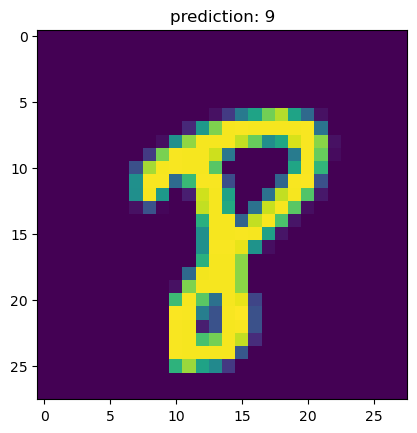

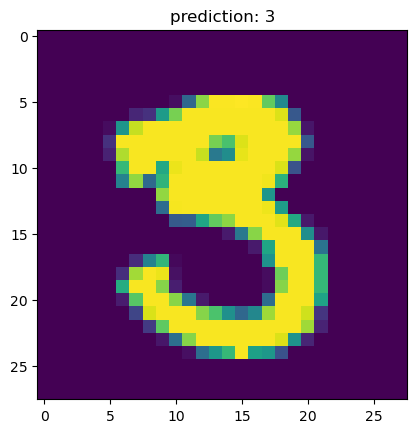

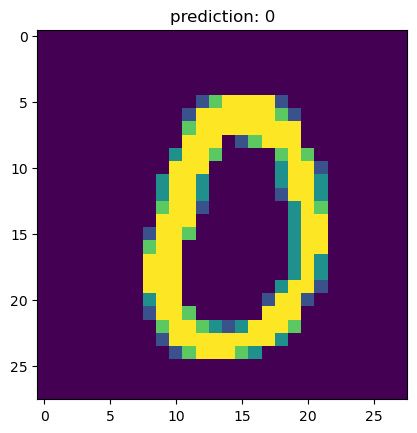

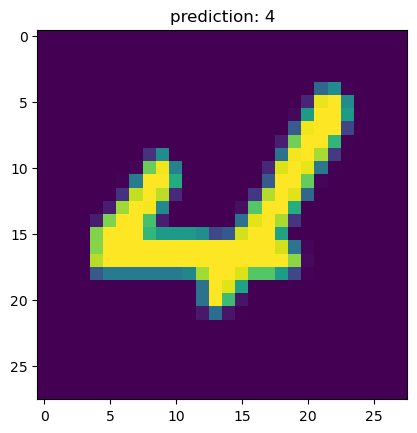

In [6]:
if __name__ == "__main__":
    main()

拟合函数：`net.forward`  
损失函数：`torch.nn.functional.nll_loss`计算损失  
优化函数：`optimizer.step()`调整参数，减小损失  
